In [1]:
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
from itertools import product
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
import seaborn as sns
from codecarbon import EmissionsTracker, track_emissions

In [2]:
def load_data_by_dimension(dimension):
    root = "./datasets/"
    data_filename = root + f'kryptonite-{dimension}-X.npy'
    labels_filename = root + f'kryptonite-{dimension}-y.npy'

    try:
        data = np.load(data_filename)
        labels = np.load(labels_filename)
        print(f"Loaded dataset with dimension {dimension}. Data shape: {data.shape}, Labels shape: {labels.shape}")
        return data, labels
    except FileNotFoundError:
        print(f"Dataset for dimension {dimension} not found.")
        return None, None

# Experiment 1: KNN Performance

## Grid Search

In [3]:
def find_best_knn_params(data, labels, search_grid=np.arange(1, 30, 2)):
    # Define the parameter grid for k in kNN
    param_grid = {'n_neighbors': search_grid}
    # Initialize the KNeighborsClassifier
    knn = KNeighborsClassifier()
    # Use GridSearchCV to find the best parameter
    grid_search = GridSearchCV(knn, param_grid, cv=5)
    grid_search.fit(data, labels)
    return grid_search.best_params_['n_neighbors'], grid_search.best_score_

In [4]:
dimensions = [9, 12, 15, 18, 24, 30, 45]
best_ks = {}
accuracies = []

# tracker = EmissionsTracker()
# tracker.start()
for dim in dimensions:
    data, labels = load_data_by_dimension(dim)
    X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.2, random_state=42)

    # find best k
    best_k, best_acc = find_best_knn_params(X_train, y_train)
    print(f"Best k for dimension {dim}: {best_k}, with accuracy {best_acc}")
    best_ks[dim]=int(best_k)
# emissions = tracker.stop()

print(best_ks)

with open("./results/knn_best_k.json", "w") as f:
    json.dump(best_ks, f) 

Loaded dataset with dimension 9. Data shape: (18000, 9), Labels shape: (18000,)
Best k for dimension 9: 9, with accuracy 0.9584722222222222
Loaded dataset with dimension 12. Data shape: (24000, 12), Labels shape: (24000,)
Best k for dimension 12: 1, with accuracy 0.9111979166666666
Loaded dataset with dimension 15. Data shape: (30000, 15), Labels shape: (30000,)
Best k for dimension 15: 1, with accuracy 0.5041666666666667
Loaded dataset with dimension 18. Data shape: (36000, 18), Labels shape: (36000,)
Best k for dimension 18: 29, with accuracy 0.5289583333333333
Loaded dataset with dimension 24. Data shape: (48000, 24), Labels shape: (48000,)
Best k for dimension 24: 3, with accuracy 0.5035416666666667
Loaded dataset with dimension 30. Data shape: (60000, 30), Labels shape: (60000,)
Best k for dimension 30: 7, with accuracy 0.5064583333333333
Loaded dataset with dimension 45. Data shape: (90000, 45), Labels shape: (90000,)
Best k for dimension 45: 3, with accuracy 0.5050416666666666
{

## Evaluation

In [4]:
dimensions = [9, 12, 15, 18, 24, 30, 45]
means = []
std_devs = []
random_seeds = [42, 123, 456, 789, 1010, 2020, 3030, 4040, 5050, 6060]
with open(f"./results/knn_best_k.json", "r") as f:
    best_ks = json.load(f)
for dim,k in zip(dimensions, best_ks.values()):
    data, labels = load_data_by_dimension(dim)
    accuracies = []
    for seed in random_seeds:
        X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.2, random_state=seed)

        model = KNeighborsClassifier(n_neighbors=k)
        model.fit(X_train, y_train)

        y_pred = model.predict(X_test)
        accuracy = accuracy_score(y_test, y_pred)
        accuracies.append(accuracy)
    means.append(np.mean(accuracies))
    std_devs.append(np.std(accuracies))

Loaded dataset with dimension 9. Data shape: (18000, 9), Labels shape: (18000,)
Loaded dataset with dimension 12. Data shape: (24000, 12), Labels shape: (24000,)
Loaded dataset with dimension 15. Data shape: (30000, 15), Labels shape: (30000,)
Loaded dataset with dimension 18. Data shape: (36000, 18), Labels shape: (36000,)
Loaded dataset with dimension 24. Data shape: (48000, 24), Labels shape: (48000,)
Loaded dataset with dimension 30. Data shape: (60000, 30), Labels shape: (60000,)
Loaded dataset with dimension 45. Data shape: (90000, 45), Labels shape: (90000,)


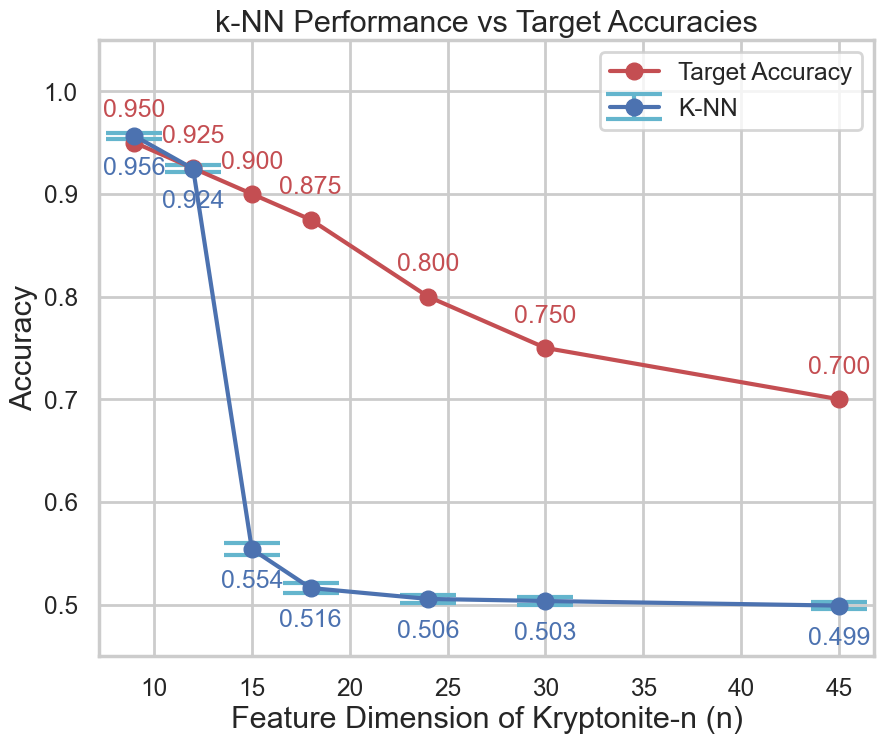

In [5]:
n = [9, 12, 15, 18, 24, 30, 45]
target_accuracies = [0.95, 0.925, 0.9, 0.875, 0.8, 0.75, 0.7]

plt.rcdefaults()
plt.figure(figsize=(10, 8))
sns.set(style="whitegrid")
sns.set_context("poster", font_scale=0.8)
plt.errorbar(dimensions, means, yerr=std_devs, label='K-NN',marker='o', linestyle='-', color='b', ecolor='c', capsize=20, capthick=3)
# Plotting target accuracies
plt.plot(n, target_accuracies, label='Target Accuracy', marker='o', linestyle='-', color='r')
for x, y in zip(dimensions, means):
    plt.text(x, y - 0.02, f'{y:.3f}', ha='center', va='top', color='b', fontsize=18)
for x, y in zip(n, target_accuracies):
    plt.text(x, y + 0.02, f'{y:.3f}', ha='center', va='bottom', color='r', fontsize=18)
plt.xlabel("Feature Dimension of Kryptonite-n (n)", fontsize=22)
plt.ylabel('Accuracy', fontsize=22)
plt.title('k-NN Performance vs Target Accuracies', fontsize=22)
plt.grid(True)
plt.ylim(0.45, 1.05)
plt.legend()
plt.show()

# Experiment 2: KNN with Feature Selection

Loaded dataset with dimension 9. Data shape: (18000, 9), Labels shape: (18000,)
Loaded dataset with dimension 12. Data shape: (24000, 12), Labels shape: (24000,)
Loaded dataset with dimension 15. Data shape: (30000, 15), Labels shape: (30000,)
Loaded dataset with dimension 18. Data shape: (36000, 18), Labels shape: (36000,)
Loaded dataset with dimension 24. Data shape: (48000, 24), Labels shape: (48000,)
Loaded dataset with dimension 30. Data shape: (60000, 30), Labels shape: (60000,)
Loaded dataset with dimension 45. Data shape: (90000, 45), Labels shape: (90000,)


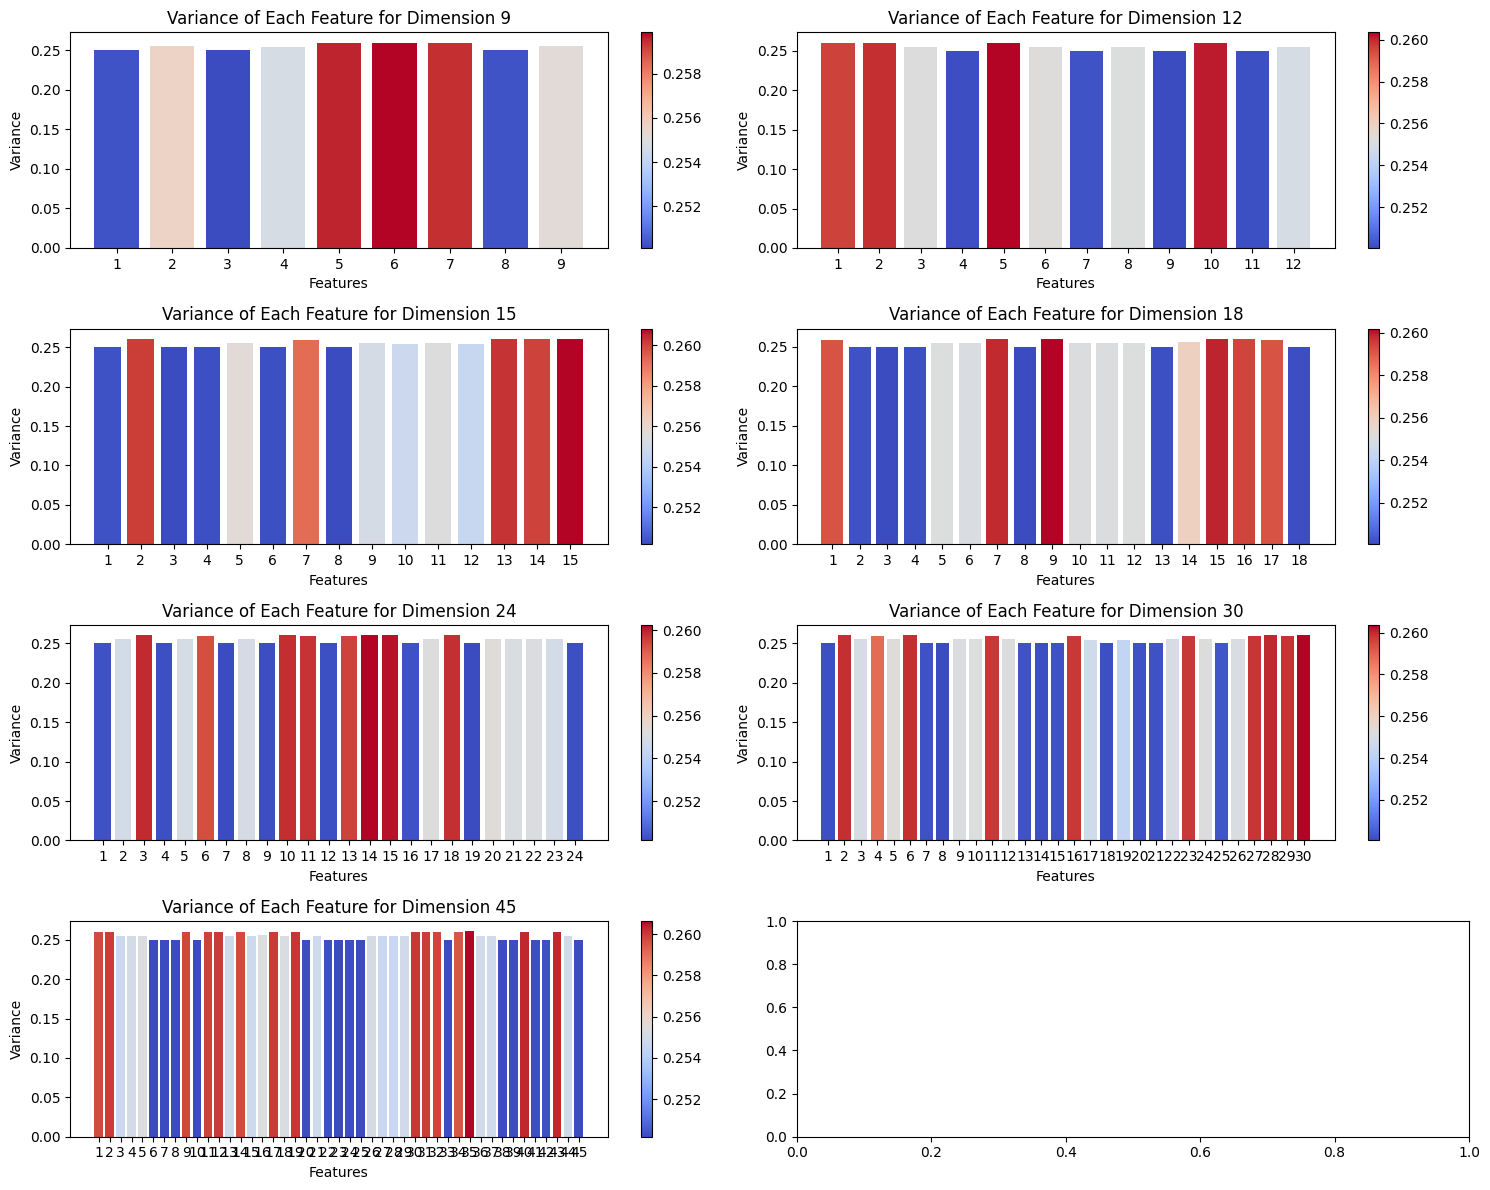

In [4]:
dimensions = [9, 12, 15, 18, 24, 30, 45]

fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(15, 12))

axes = axes.flatten()
for i, dim in enumerate(dimensions):
    data, labels = load_data_by_dimension(dim)
    # data = scaler.fit_transform(data)
    df = pd.DataFrame(data, columns=[f"{i + 1}" for i in range(data.shape[1])])
    df['Label'] = labels
    variances = df.drop('Label', axis=1).var()
    norm = plt.Normalize(variances.min(), variances.max())
    cmap = plt.get_cmap("coolwarm")
    colors = cmap(norm(variances.values))

    bars = axes[i].bar(variances.index, variances.values, color=colors)
    # axes[i].bar(variances.index, variances.values)
    axes[i].set_title(f'Variance of Each Feature for Dimension {dim}')
    axes[i].set_xlabel('Features')
    axes[i].set_ylabel('Variance')

    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])
    fig.colorbar(sm, ax=axes[i])

plt.tight_layout()
plt.show()


## Grid search for variance threshold and K

In [6]:
def preprocess_data(data, variance_threshold):
    variances = np.var(data, axis=0)
    
    retained_features = np.where(variances >= variance_threshold)[0]
    
    return data[:, retained_features], retained_features.tolist()

In [17]:
# @track_emissions(project_name="KNNvariance")
def perform_grid_search(dim, k_range):
    data, labels = load_data_by_dimension(dim)
    thresholds = list(np.unique(np.sort(np.var(data, axis=0))))
    accuracies = {t: [] for t in thresholds}
    best_acc = 0
    best_params = {}

    for t, k in product(thresholds, k_range):
        data_processed, retained_features = preprocess_data(data, variance_threshold=t)
        X_train, X_test, y_train, y_test = train_test_split(data_processed, labels, test_size=0.2, random_state=42)

        model = KNeighborsClassifier(n_neighbors=k)
        acc = np.mean(cross_val_score(model, X_train, y_train, cv=5))
        accuracies[t].append(acc)
        if acc > best_acc:
            best_acc = acc
            best_params = {"Threshold": t, "K": k,"Features" :retained_features}

    plt.figure(figsize=(10, 6))
    for t in thresholds:
        plt.plot(k_range, accuracies[t], label=f"Threshold {t}")

    plt.title(f"Accuracy vs K for Dimension {dim}")
    plt.xlabel("K")
    plt.ylabel("Accuracy")
    # plt.legend()
    plt.grid(True)
    plt.ylim(0, 1)
    plt.show()
    return best_params, best_acc

In [8]:
k_range = range(1, 30, 2)

### Entire Grid Search

[codecarbon INFO @ 02:39:00] [setup] RAM Tracking...
[codecarbon INFO @ 02:39:00] [setup] GPU Tracking...
[codecarbon INFO @ 02:39:00] Tracking Nvidia GPU via pynvml
[codecarbon INFO @ 02:39:00] [setup] CPU Tracking...
[codecarbon WARNING @ 02:39:00] No CPU tracking mode found. Falling back on CPU constant mode. 
 Linux OS detected: Please ensure RAPL files exist at \sys\class\powercap\intel-rapl to measure CPU

[codecarbon INFO @ 02:39:02] CPU Model on constant consumption mode: AMD Ryzen 7 5800H with Radeon Graphics
[codecarbon INFO @ 02:39:02] >>> Tracker's metadata:
[codecarbon INFO @ 02:39:02]   Platform system: Linux-5.15.167.4-microsoft-standard-WSL2-x86_64-with-glibc2.35
[codecarbon INFO @ 02:39:02]   Python version: 3.10.12
[codecarbon INFO @ 02:39:02]   CodeCarbon version: 2.7.4
[codecarbon INFO @ 02:39:02]   Available RAM : 7.440 GB
[codecarbon INFO @ 02:39:02]   CPU count: 16
[codecarbon INFO @ 02:39:02]   CPU model: AMD Ryzen 7 5800H with Radeon Graphics
[codecarbon INFO @

Loaded dataset with dimension 9. Data shape: (18000, 9), Labels shape: (18000,)


[codecarbon INFO @ 02:39:20] Energy consumed for RAM : 0.000012 kWh. RAM Power : 2.789916515350342 W
[codecarbon INFO @ 02:39:20] Energy consumed for all GPUs : 0.000044 kWh. Total GPU Power : 10.603865662910067 W
[codecarbon INFO @ 02:39:20] Energy consumed for all CPUs : 0.000113 kWh. Total CPU Power : 27.0 W
[codecarbon INFO @ 02:39:20] 0.000168 kWh of electricity used since the beginning.
[codecarbon INFO @ 02:39:35] Energy consumed for RAM : 0.000023 kWh. RAM Power : 2.789916515350342 W
[codecarbon INFO @ 02:39:35] Energy consumed for all GPUs : 0.000085 kWh. Total GPU Power : 9.780511429528454 W
[codecarbon INFO @ 02:39:35] Energy consumed for all CPUs : 0.000225 kWh. Total CPU Power : 27.0 W
[codecarbon INFO @ 02:39:35] 0.000333 kWh of electricity used since the beginning.
[codecarbon INFO @ 02:39:50] Energy consumed for RAM : 0.000035 kWh. RAM Power : 2.789916515350342 W
[codecarbon INFO @ 02:39:50] Energy consumed for all GPUs : 0.000126 kWh. Total GPU Power : 9.74683230116001

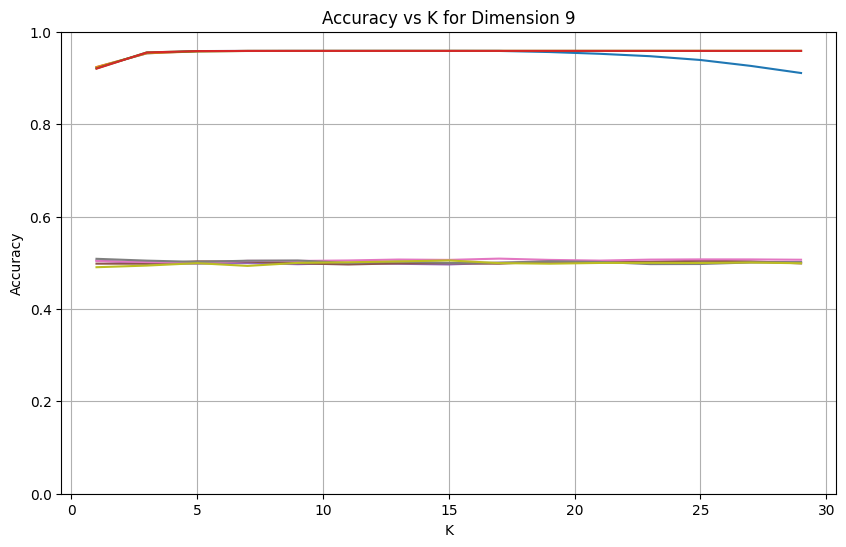

Loaded dataset with dimension 12. Data shape: (24000, 12), Labels shape: (24000,)


[codecarbon INFO @ 02:40:05] Energy consumed for RAM : 0.000046 kWh. RAM Power : 2.789916515350342 W
[codecarbon INFO @ 02:40:05] Energy consumed for all GPUs : 0.000172 kWh. Total GPU Power : 11.251308434874106 W
[codecarbon INFO @ 02:40:05] Energy consumed for all CPUs : 0.000450 kWh. Total CPU Power : 27.0 W
[codecarbon INFO @ 02:40:05] 0.000669 kWh of electricity used since the beginning.
[codecarbon INFO @ 02:40:20] Energy consumed for RAM : 0.000058 kWh. RAM Power : 2.789916515350342 W
[codecarbon INFO @ 02:40:20] Energy consumed for all GPUs : 0.000216 kWh. Total GPU Power : 10.410904182347934 W
[codecarbon INFO @ 02:40:20] Energy consumed for all CPUs : 0.000562 kWh. Total CPU Power : 27.0 W
[codecarbon INFO @ 02:40:20] 0.000836 kWh of electricity used since the beginning.
[codecarbon INFO @ 02:40:35] Energy consumed for RAM : 0.000070 kWh. RAM Power : 2.789916515350342 W
[codecarbon INFO @ 02:40:35] Energy consumed for all GPUs : 0.000256 kWh. Total GPU Power : 9.6456363024407

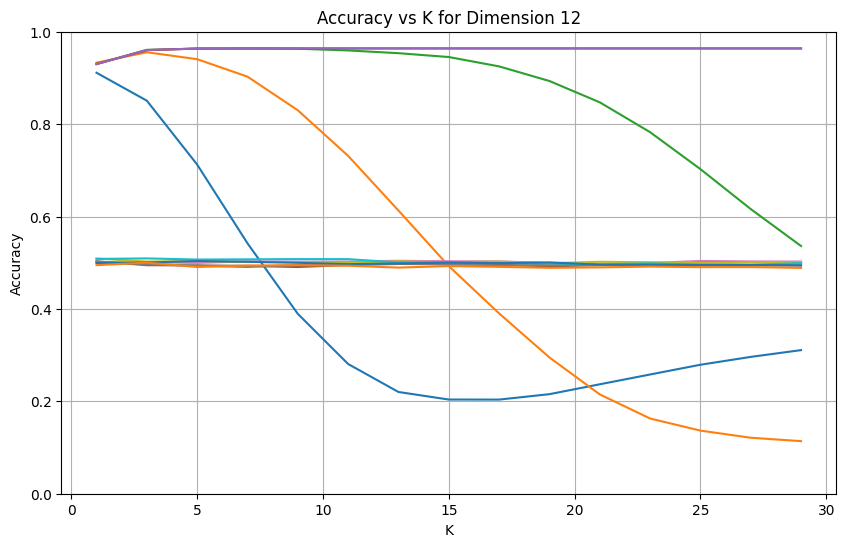

Loaded dataset with dimension 15. Data shape: (30000, 15), Labels shape: (30000,)


[codecarbon INFO @ 02:42:35] Energy consumed for RAM : 0.000163 kWh. RAM Power : 2.789916515350342 W
[codecarbon INFO @ 02:42:35] Energy consumed for all GPUs : 0.000615 kWh. Total GPU Power : 10.3201675800592 W
[codecarbon INFO @ 02:42:35] Energy consumed for all CPUs : 0.001575 kWh. Total CPU Power : 27.0 W
[codecarbon INFO @ 02:42:35] 0.002353 kWh of electricity used since the beginning.
[codecarbon INFO @ 02:42:50] Energy consumed for RAM : 0.000174 kWh. RAM Power : 2.789916515350342 W
[codecarbon INFO @ 02:42:50] Energy consumed for all GPUs : 0.000662 kWh. Total GPU Power : 11.295565760005159 W
[codecarbon INFO @ 02:42:50] Energy consumed for all CPUs : 0.001687 kWh. Total CPU Power : 27.0 W
[codecarbon INFO @ 02:42:50] 0.002524 kWh of electricity used since the beginning.
[codecarbon INFO @ 02:43:05] Energy consumed for RAM : 0.000186 kWh. RAM Power : 2.789916515350342 W
[codecarbon INFO @ 02:43:05] Energy consumed for all GPUs : 0.000709 kWh. Total GPU Power : 11.1869020888965 

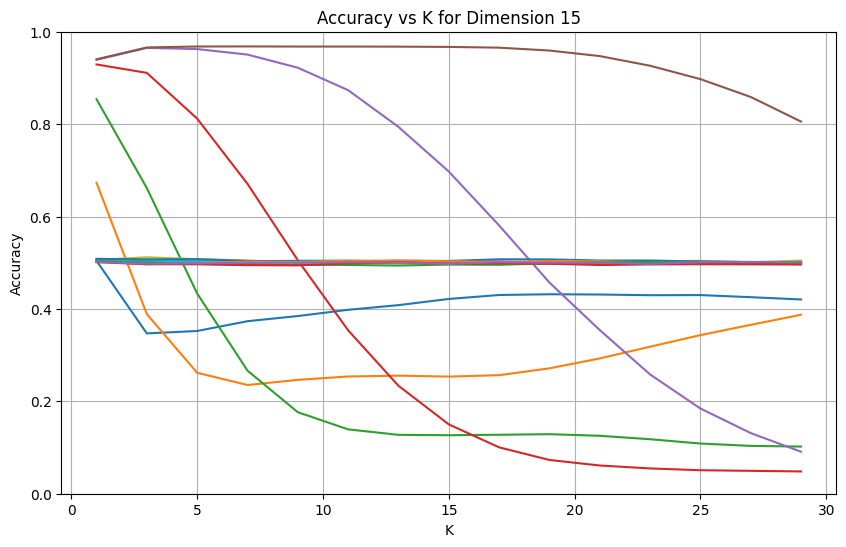

Loaded dataset with dimension 18. Data shape: (36000, 18), Labels shape: (36000,)


[codecarbon INFO @ 02:48:05] Energy consumed for RAM : 0.000418 kWh. RAM Power : 2.789916515350342 W
[codecarbon INFO @ 02:48:05] Energy consumed for all GPUs : 0.001605 kWh. Total GPU Power : 10.243067798973417 W
[codecarbon INFO @ 02:48:05] Energy consumed for all CPUs : 0.004050 kWh. Total CPU Power : 27.0 W
[codecarbon INFO @ 02:48:05] 0.006073 kWh of electricity used since the beginning.
[codecarbon INFO @ 02:48:20] Energy consumed for RAM : 0.000430 kWh. RAM Power : 2.789916515350342 W
[codecarbon INFO @ 02:48:20] Energy consumed for all GPUs : 0.001651 kWh. Total GPU Power : 11.138603403542117 W
[codecarbon INFO @ 02:48:20] Energy consumed for all CPUs : 0.004162 kWh. Total CPU Power : 27.0 W
[codecarbon INFO @ 02:48:20] 0.006243 kWh of electricity used since the beginning.
[codecarbon INFO @ 02:48:35] Energy consumed for RAM : 0.000441 kWh. RAM Power : 2.789916515350342 W
[codecarbon INFO @ 02:48:35] Energy consumed for all GPUs : 0.001695 kWh. Total GPU Power : 10.556656086394

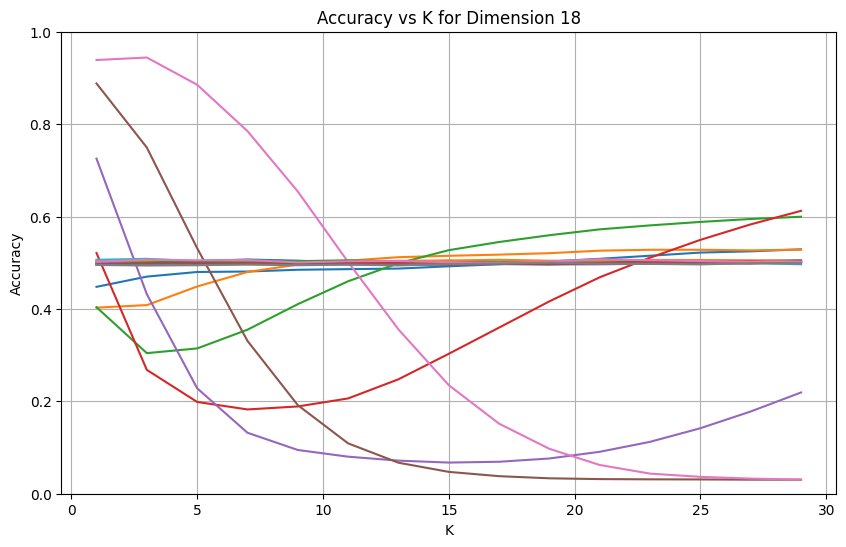

Loaded dataset with dimension 24. Data shape: (48000, 24), Labels shape: (48000,)


[codecarbon INFO @ 02:55:35] Energy consumed for RAM : 0.000767 kWh. RAM Power : 2.789916515350342 W
[codecarbon INFO @ 02:55:35] Energy consumed for all GPUs : 0.002930 kWh. Total GPU Power : 9.96659848134453 W
[codecarbon INFO @ 02:55:35] Energy consumed for all CPUs : 0.007424 kWh. Total CPU Power : 27.0 W
[codecarbon INFO @ 02:55:35] 0.011120 kWh of electricity used since the beginning.
[codecarbon INFO @ 02:55:50] Energy consumed for RAM : 0.000778 kWh. RAM Power : 2.789916515350342 W
[codecarbon INFO @ 02:55:50] Energy consumed for all GPUs : 0.002977 kWh. Total GPU Power : 11.386639882695558 W
[codecarbon INFO @ 02:55:50] Energy consumed for all CPUs : 0.007536 kWh. Total CPU Power : 27.0 W
[codecarbon INFO @ 02:55:50] 0.011292 kWh of electricity used since the beginning.
[codecarbon INFO @ 02:56:05] Energy consumed for RAM : 0.000790 kWh. RAM Power : 2.789916515350342 W
[codecarbon INFO @ 02:56:05] Energy consumed for all GPUs : 0.003022 kWh. Total GPU Power : 10.64918723658796

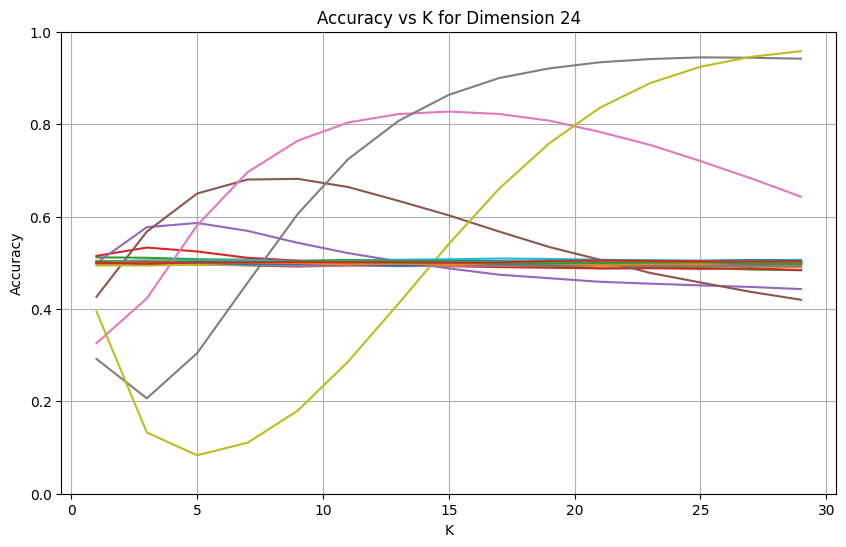

Loaded dataset with dimension 30. Data shape: (60000, 30), Labels shape: (60000,)


[codecarbon INFO @ 03:07:35] Energy consumed for RAM : 0.001309 kWh. RAM Power : 2.789916515350342 W
[codecarbon INFO @ 03:07:35] Energy consumed for all GPUs : 0.006562 kWh. Total GPU Power : 24.49008953540979 W
[codecarbon INFO @ 03:07:35] Energy consumed for all CPUs : 0.012823 kWh. Total CPU Power : 27.0 W
[codecarbon INFO @ 03:07:35] 0.020694 kWh of electricity used since the beginning.
[codecarbon INFO @ 03:07:50] Energy consumed for RAM : 0.001320 kWh. RAM Power : 2.789916515350342 W
[codecarbon INFO @ 03:07:50] Energy consumed for all GPUs : 0.006660 kWh. Total GPU Power : 23.535355827433527 W
[codecarbon INFO @ 03:07:50] Energy consumed for all CPUs : 0.012936 kWh. Total CPU Power : 27.0 W
[codecarbon INFO @ 03:07:50] 0.020916 kWh of electricity used since the beginning.
[codecarbon INFO @ 03:08:05] Energy consumed for RAM : 0.001332 kWh. RAM Power : 2.789916515350342 W
[codecarbon INFO @ 03:08:05] Energy consumed for all GPUs : 0.006765 kWh. Total GPU Power : 25.3238282581054

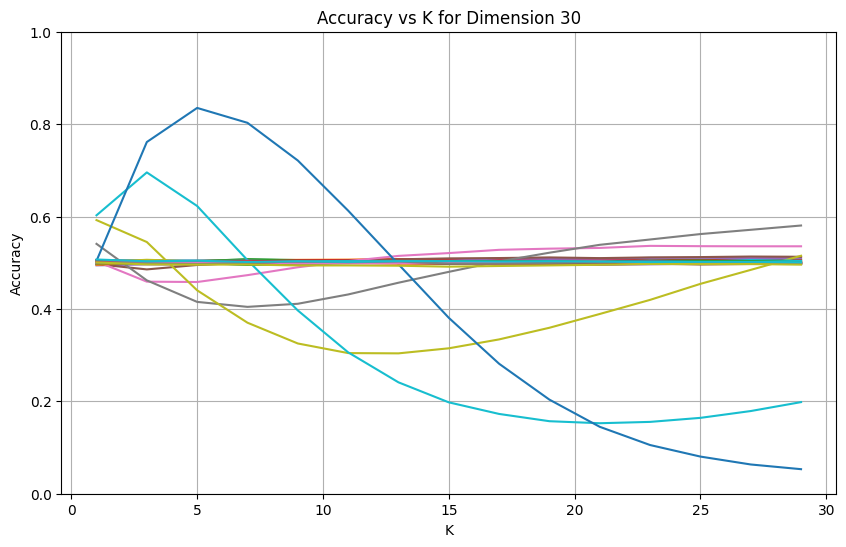

Loaded dataset with dimension 45. Data shape: (90000, 45), Labels shape: (90000,)


[codecarbon INFO @ 03:25:21] Energy consumed for all GPUs : 0.012360 kWh. Total GPU Power : 13.424131984980724 W
[codecarbon INFO @ 03:25:21] Energy consumed for all CPUs : 0.020819 kWh. Total CPU Power : 27.0 W
[codecarbon INFO @ 03:25:21] 0.035290 kWh of electricity used since the beginning.
[codecarbon INFO @ 03:25:35] Energy consumed for RAM : 0.002122 kWh. RAM Power : 2.789916515350342 W
[codecarbon INFO @ 03:25:35] Energy consumed for all GPUs : 0.012454 kWh. Total GPU Power : 24.565951381455065 W
[codecarbon INFO @ 03:25:35] Energy consumed for all CPUs : 0.020923 kWh. Total CPU Power : 27.0 W
[codecarbon INFO @ 03:25:35] 0.035499 kWh of electricity used since the beginning.
[codecarbon INFO @ 03:25:50] Energy consumed for RAM : 0.002133 kWh. RAM Power : 2.789916515350342 W
[codecarbon INFO @ 03:25:51] Energy consumed for all GPUs : 0.012517 kWh. Total GPU Power : 15.03385327934111 W
[codecarbon INFO @ 03:25:51] Energy consumed for all CPUs : 0.021044 kWh. Total CPU Power : 27.0

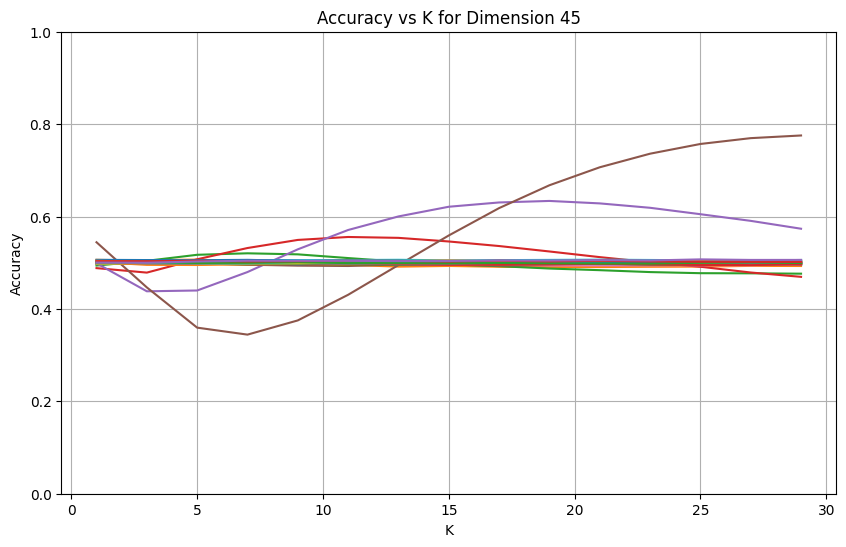

[codecarbon INFO @ 04:12:52] Energy consumed for RAM : 0.004273 kWh. RAM Power : 2.789916515350342 W
[codecarbon INFO @ 04:12:52] Energy consumed for all GPUs : 0.028654 kWh. Total GPU Power : 26.597355054990594 W
[codecarbon INFO @ 04:12:52] Energy consumed for all CPUs : 0.042200 kWh. Total CPU Power : 27.0 W
[codecarbon INFO @ 04:12:52] 0.075128 kWh of electricity used since the beginning.
[codecarbon INFO @ 04:12:53] 0.003292 g.CO2eq/s mean an estimation of 103.82657860047951 kg.CO2eq/year


Params: [{'Threshold': 0.2500982, 'K': 9}, {'Threshold': 0.25020212, 'K': 7}, {'Threshold': 0.25468698, 'K': 7}, {'Threshold': 0.25496775, 'K': 3}, {'Threshold': 0.25480804, 'K': 29}, {'Threshold': 0.25431716, 'K': 5}, {'Threshold': 0.2546372, 'K': 29}]	Accuracies: [0.9584722222222222, 0.9638541666666667, 0.9681666666666666, 0.9441666666666666, 0.9579166666666665, 0.8350625, 0.7754166666666666]


/home/jjluhilson/.local/lib/python3.10/site-packages/codecarbon/output_methods/file.py:52: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df, pd.DataFrame.from_records([dict(total.values)])])


In [9]:
dimensions = [9, 12, 15, 18, 24, 30, 45]
best_parameters = []
best_accuracies = []

tracker = EmissionsTracker()
tracker.start()
for i in dimensions:
    best_params,best_acc = perform_grid_search(i,k_range)
    best_parameters.append(best_params)
    best_accuracies.append(best_acc)
    with open(f"./results/knn_best_config_dim{i}.json", "w") as f:
        json.dump(best_params, f)
emissions = tracker.stop()

print(f"Params: {best_parameters}\tAccuracies: {best_accuracies}")

In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(dimensions, best_accuracies, marker='o', linestyle='-', color='b')
plt.xlabel('Number of Dimensions')
plt.ylabel('Accuracy')
plt.title('kNN Performance vs. Dimensionality')
plt.grid(True)
plt.show()

### Dimension by Dimension

Loaded dataset with dimension 9. Data shape: (18000, 9), Labels shape: (18000,)


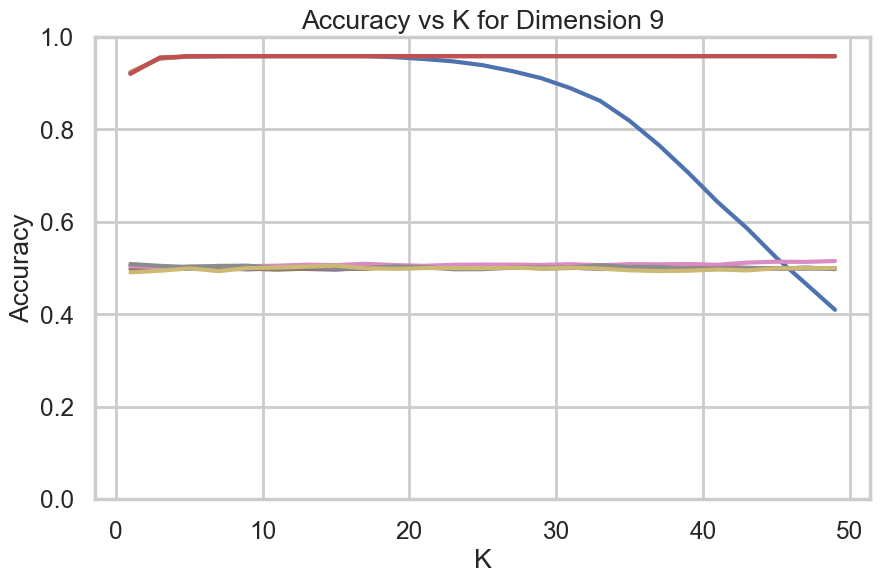

Best combination for Dimension 9:
Threshold: 0.25009819865226746, K: 9, Accuracy: 0.9584722222222222


In [57]:
best_params, best_acc = perform_grid_search(9, k_range)
print(f"Best combination for Dimension 9:")
print(f"Threshold: {best_params['Threshold']}, K: {best_params['K']}, Accuracy: {best_acc}")

Loaded dataset with dimension 12. Data shape: (24000, 12), Labels shape: (24000,)


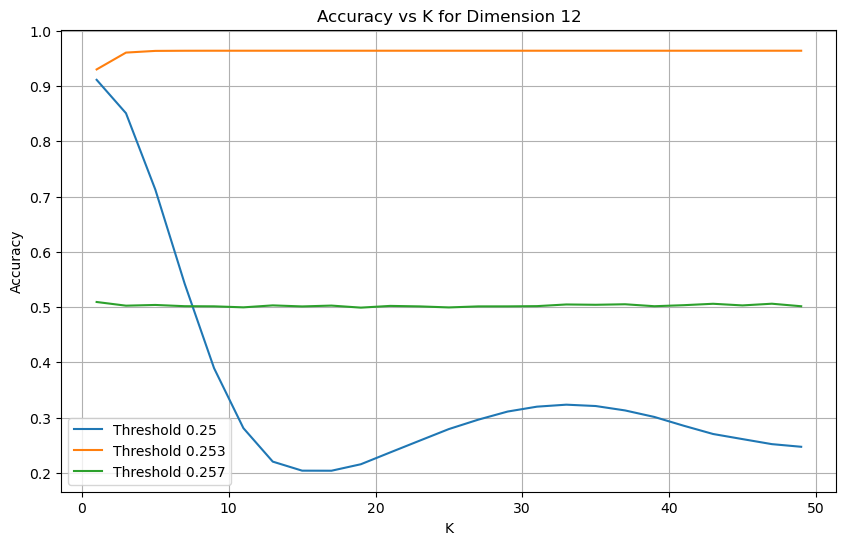

Best combination for Dimension 12:
Threshold: 0.253, K: 9, Accuracy: 0.9638541666666667


In [22]:
best_params, best_acc = perform_grid_search(12, k_range)
print(f"Best combination for Dimension 12:")
print(f"Threshold: {best_params['Threshold']}, K: {best_params['K']}, Accuracy: {best_acc}")

Loaded dataset with dimension 15. Data shape: (30000, 15), Labels shape: (30000,)


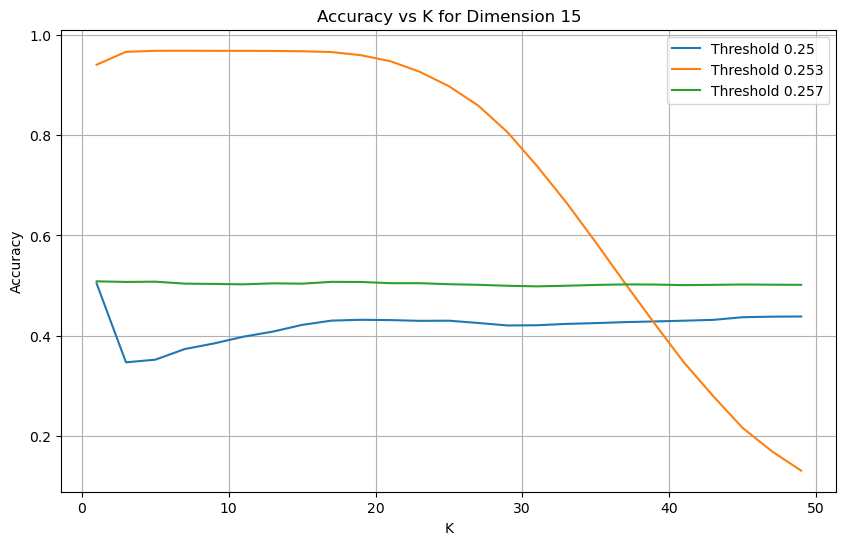

Best combination for Dimension 15:
Threshold: 0.253, K: 7, Accuracy: 0.9681666666666666


In [23]:
best_params, best_acc = perform_grid_search(15, k_range)
print(f"Best combination for Dimension 15:")
print(f"Threshold: {best_params['Threshold']}, K: {best_params['K']}, Accuracy: {best_acc}")

Loaded dataset with dimension 18. Data shape: (36000, 18), Labels shape: (36000,)


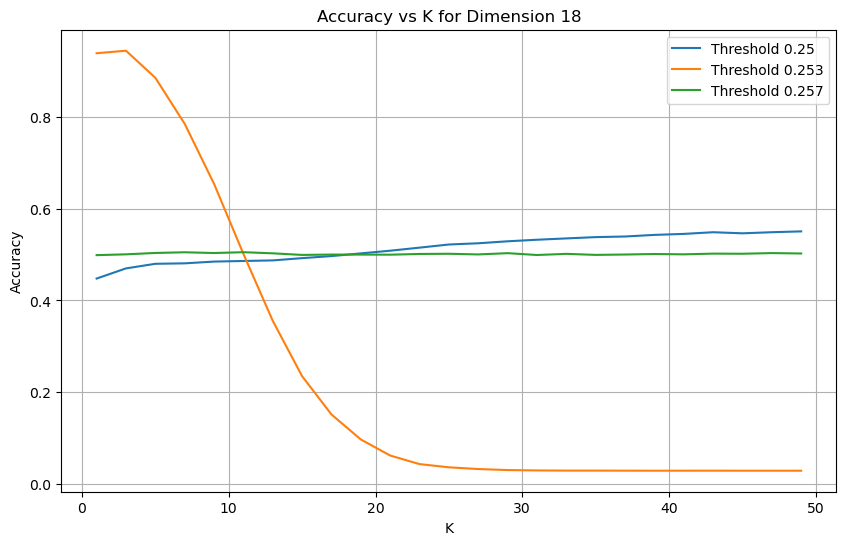

Best combination for Dimension 18:
Threshold: 0.253, K: 3, Accuracy: 0.9441666666666666


In [24]:
best_params, best_acc = perform_grid_search(18, k_range)
print(f"Best combination for Dimension 18:")
print(f"Threshold: {best_params['Threshold']}, K: {best_params['K']}, Accuracy: {best_acc}")

Loaded dataset with dimension 24. Data shape: (48000, 24), Labels shape: (48000,)


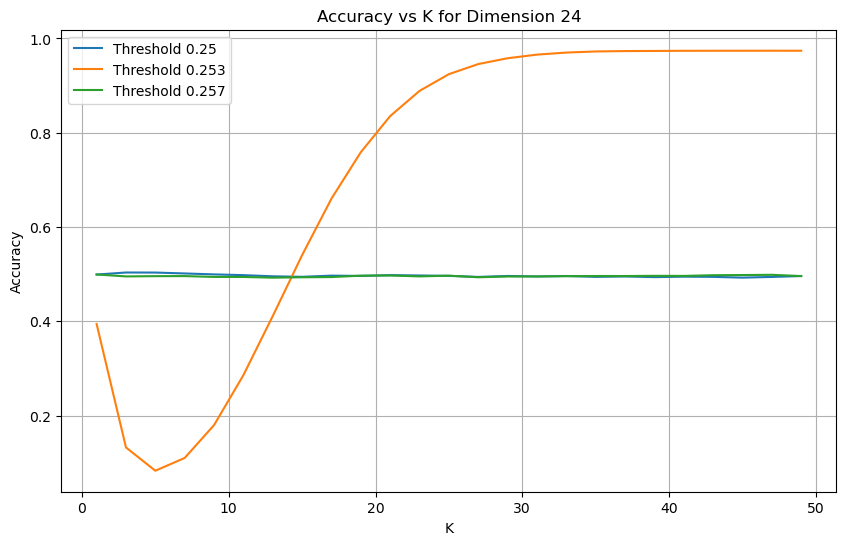

Best combination for Dimension 24:
Threshold: 0.253, K: 47, Accuracy: 0.9738541666666667


In [25]:
best_params, best_acc = perform_grid_search(24, k_range)
print(f"Best combination for Dimension 24:")
print(f"Threshold: {best_params['Threshold']}, K: {best_params['K']}, Accuracy: {best_acc}")

Loaded dataset with dimension 30. Data shape: (60000, 30), Labels shape: (60000,)


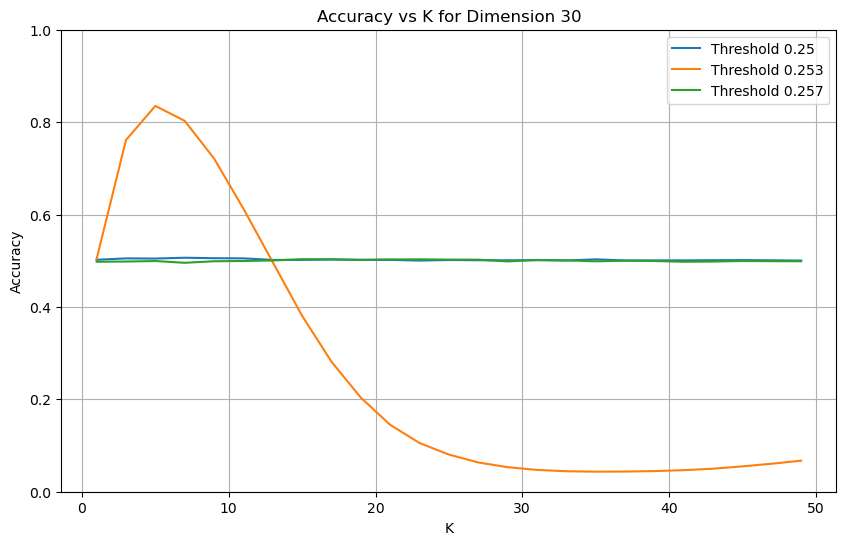

Best combination for Dimension 30:
Threshold: 0.253, K: 5, Accuracy: 0.8350625


In [27]:
best_params, best_acc = perform_grid_search(30, k_range)
print(f"Best combination for Dimension 30:")
print(f"Threshold: {best_params['Threshold']}, K: {best_params['K']}, Accuracy: {best_acc}")

Loaded dataset with dimension 45. Data shape: (90000, 45), Labels shape: (90000,)


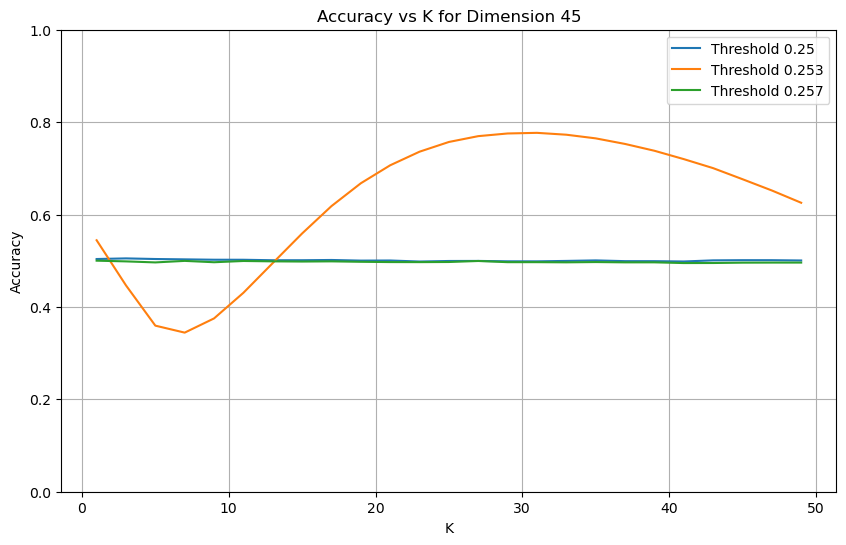

Best combination for Dimension 45:
Threshold: 0.253, K: 31, Accuracy: 0.7767916666666668


In [28]:
best_params, best_acc = perform_grid_search(45, k_range)
print(f"Best combination for Dimension 45:")
print(f"Threshold: {best_params['Threshold']}, K: {best_params['K']}, Accuracy: {best_acc}")

## Evaluation

In [8]:
dimensions = [9, 12, 15, 18, 24, 30, 45]
means_reduction = []
std_devs_reduction = []
random_seeds = [42, 123, 456, 789, 1010, 2020, 3030, 4040, 5050, 6060]

# tracker = EmissionsTracker()
# tracker.start()
for dim in dimensions:
    with open(f"./results/knn_best_config_dim{dim}.json", "r") as f:
        best = json.load(f)
    data, labels = load_data_by_dimension(dim)
    # data, _ = preprocess_data(data, variance_threshold=best["Threshold"])
    data = data[:,best["Features"]]
    accuracies = []
    for seed in random_seeds:
        X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.2, random_state=seed)
        model = KNeighborsClassifier(n_neighbors=best["K"])
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        accuracy = accuracy_score(y_test, y_pred)
        accuracies.append(accuracy)
    means_reduction.append(np.mean(accuracies))
    std_devs_reduction.append(np.std(accuracies))

# emissions = tracker.stop()

Loaded dataset with dimension 9. Data shape: (18000, 9), Labels shape: (18000,)
Loaded dataset with dimension 12. Data shape: (24000, 12), Labels shape: (24000,)
Loaded dataset with dimension 15. Data shape: (30000, 15), Labels shape: (30000,)
Loaded dataset with dimension 18. Data shape: (36000, 18), Labels shape: (36000,)
Loaded dataset with dimension 24. Data shape: (48000, 24), Labels shape: (48000,)
Loaded dataset with dimension 30. Data shape: (60000, 30), Labels shape: (60000,)
Loaded dataset with dimension 45. Data shape: (90000, 45), Labels shape: (90000,)


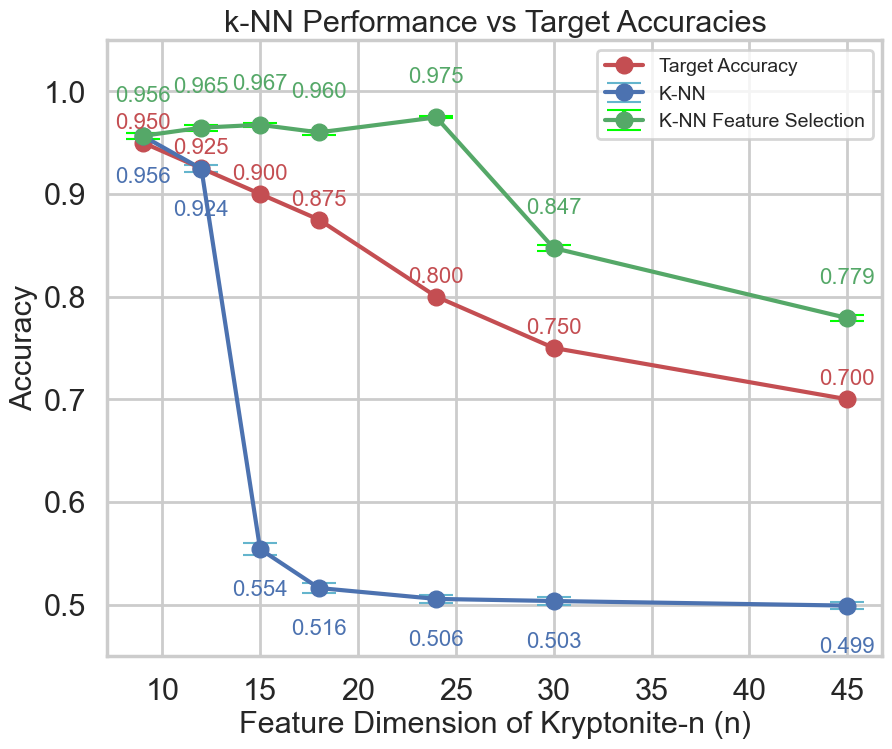

In [9]:
n = [9, 12, 15, 18, 24, 30, 45]
target_accuracies = [0.95, 0.925, 0.9, 0.875, 0.8, 0.75, 0.7]

# Plotting settings
sns.set(style="whitegrid")
sns.set_context("poster", font_scale=1)
plt.figure(figsize=(10, 8))

# Plotting kNN performance
plt.errorbar(n, means, label='K-NN', yerr=std_devs, marker='o', linestyle='-', color='b', ecolor='c', capsize=12,
             capthick=1.5)
plt.errorbar(n, means_reduction, label='K-NN Feature Selection', yerr=std_devs_reduction, marker='o', linestyle='-',
             color='g', ecolor='lime', capsize=12, capthick=1.5)

# Plotting target accuracies
plt.plot(n, target_accuracies, label='Target Accuracy', marker='o', linestyle='-', color='r')

# Annotating points for better clarity
for x, y in zip(dimensions, means):
    plt.text(x, y - 0.03, f'{y:.3f}', ha='center', va='top', color='b', fontsize=16)
for x, y in zip(dimensions, means_reduction):
    plt.text(x, y + 0.03, f'{y:.3f}', ha='center', va='bottom', color='g', fontsize=16)

for x, y in zip(n, target_accuracies):
    plt.text(x, y + 0.01, f'{y:.3f}', ha='center', va='bottom', color='r', fontsize=16)

plt.title("k-NN Performance vs Target Accuracies", fontsize=22)
plt.ylabel("Accuracy", fontsize=22)
plt.xlabel("Feature Dimension of Kryptonite-n (n)", fontsize=22)
plt.legend(fontsize=14, loc='upper right')

# Adjusting axis limits for better visual clarity
plt.ylim(0.45, 1.05)
# plt.xlim(8, 46)

# plt.tight_layout()
plt.show()


# Experiment 3: KNN performance with different distance weights

## Grid search

In [15]:
@track_emissions(project_name="KNNksearch")
def plot_optimal_k(dim, krange):
    data, labels = load_data_by_dimension(dim)
    data, _ = preprocess_data(data, variance_threshold=0.253)
    X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.2, random_state=42)
    accuracies_distance = []
    accuracies = []
    for k in krange:
        model = KNeighborsClassifier(n_neighbors=k, weights='uniform')
        model_distance = KNeighborsClassifier(n_neighbors=k, weights='distance')
        acc = cross_val_score(model, X_train, y_train, cv=5)
        acc_distance = cross_val_score(model_distance, X_train, y_train, cv=5)
        accuracies_distance.append(np.mean(acc_distance))
        accuracies.append(np.mean(acc))
    plt.rcdefaults()
    plt.figure(figsize=(10, 5))
    plt.plot(krange, accuracies, label="uniform", marker='o', linestyle='-', color='b')
    plt.plot(krange, accuracies_distance, label="distance", marker='o', linestyle='-', color='r')
    plt.ylim(0, 1)
    plt.xlabel('Value of K')
    plt.ylabel('Accuracy')
    plt.title(f'kNN Performance for different K (dim={dim})')
    plt.legend()
    plt.grid(True)
    plt.show()

### kryptonite-9

Loaded dataset with dimension 9. Data shape: (18000, 9), Labels shape: (18000,)


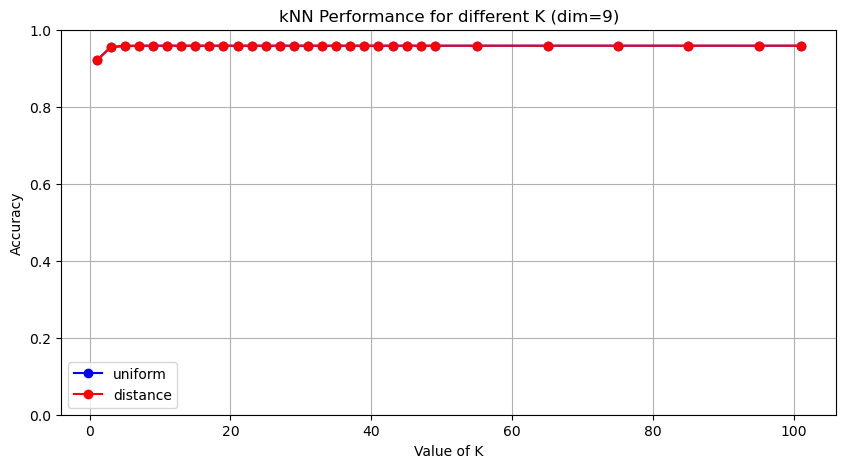

In [18]:
krange = list(range(1, 50, 2)) + [55, 65, 75, 85, 95, 101]
plot_optimal_k(9, krange)

### kryptonite-12

Loaded dataset with dimension 12. Data shape: (24000, 12), Labels shape: (24000,)


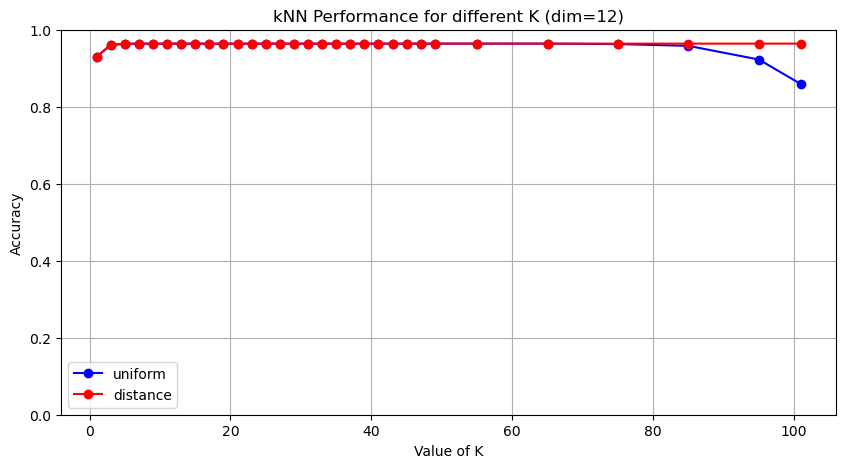

In [19]:
plot_optimal_k(12, krange)

### kryptonite-15

Loaded dataset with dimension 15. Data shape: (30000, 15), Labels shape: (30000,)


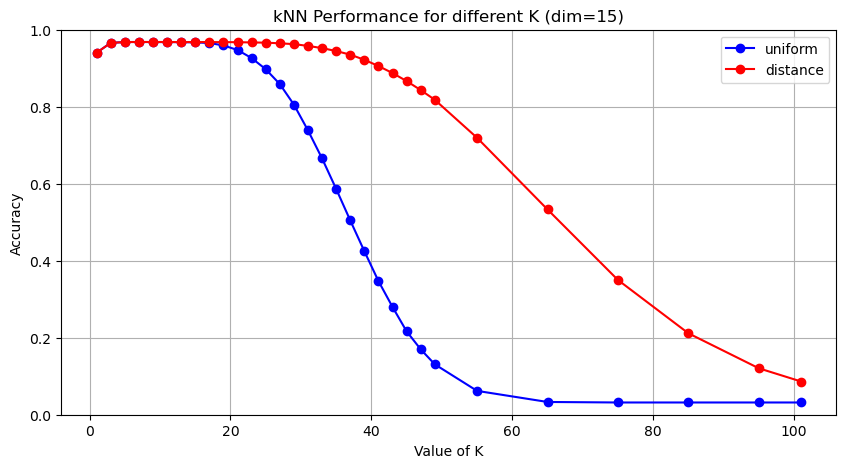

In [20]:
plot_optimal_k(15, krange)

### kryptonite-18

Loaded dataset with dimension 18. Data shape: (36000, 18), Labels shape: (36000,)


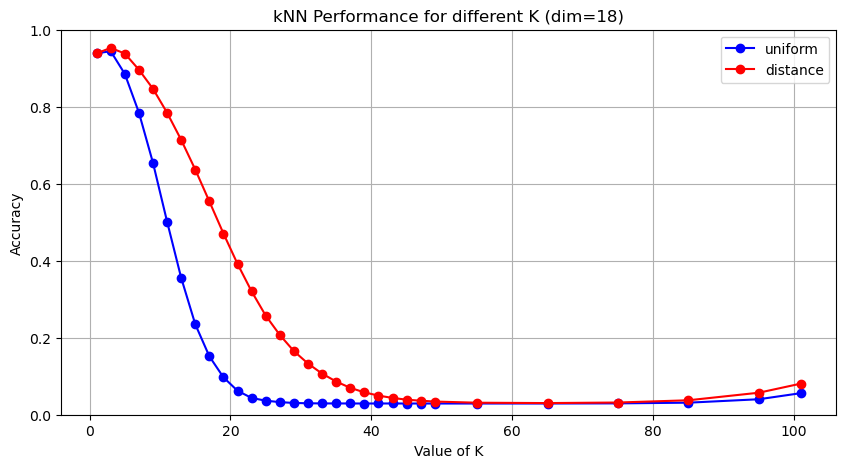

In [21]:
plot_optimal_k(18, krange)

### kryptonite-24


Loaded dataset with dimension 24. Data shape: (48000, 24), Labels shape: (48000,)


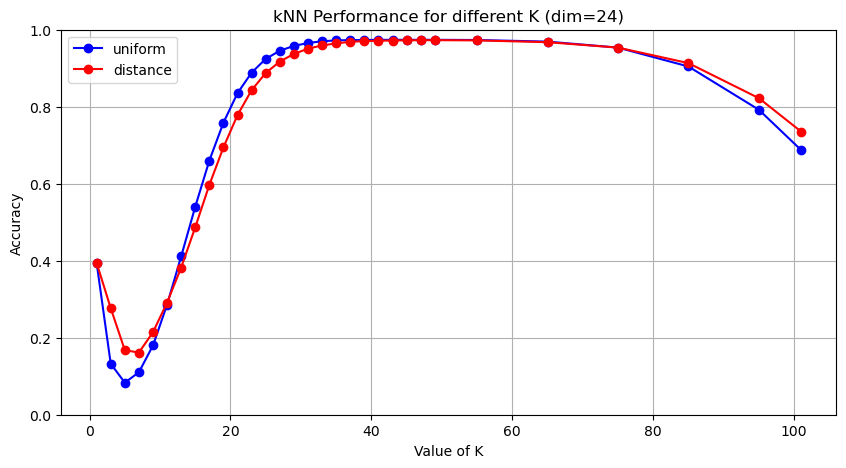

In [22]:
plot_optimal_k(24, krange)

### kryptonite-30

Loaded dataset with dimension 30. Data shape: (60000, 30), Labels shape: (60000,)


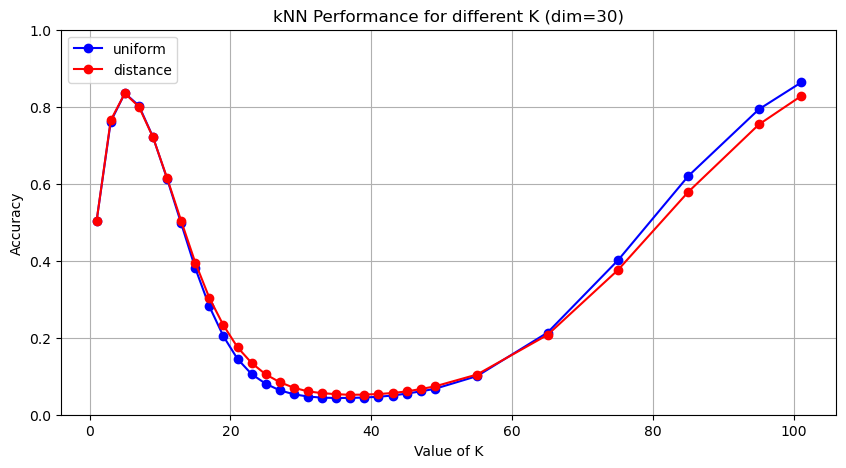

In [23]:
plot_optimal_k(30, krange)
# the model basically predicts the label the datapoint is not in at k-39, thus should flip the output

### kryptonite-45

Loaded dataset with dimension 45. Data shape: (90000, 45), Labels shape: (90000,)


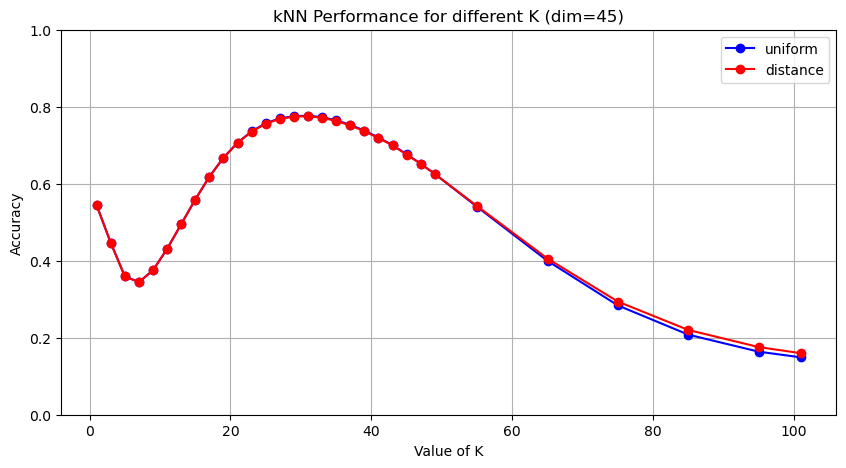

In [24]:
plot_optimal_k(45, krange)

## Evaluation

In [10]:
dimensions = [9, 12, 15, 18, 24, 30, 45]
means_distance = []
std_devs_distance = []
random_seeds = [42, 123, 456, 789, 1010, 2020, 3030, 4040, 5050, 6060]
for dim in dimensions:
    with open(f"./results/knn_best_config_dim{dim}.json", "r") as f:
        best = json.load(f)
    data, labels = load_data_by_dimension(dim)
    # data, _ = preprocess_data(data, variance_threshold=best["Threshold"])
    data = data[:,best["Features"]]
    accuracies = []
    for seed in random_seeds:
        X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.2, random_state=seed)
        model = KNeighborsClassifier(n_neighbors=best["K"], weights="distance")
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        accuracy = accuracy_score(y_test, y_pred)
        accuracies.append(accuracy)
    means_distance.append(np.mean(accuracies))
    std_devs_distance.append(np.std(accuracies))

Loaded dataset with dimension 9. Data shape: (18000, 9), Labels shape: (18000,)
Loaded dataset with dimension 12. Data shape: (24000, 12), Labels shape: (24000,)
Loaded dataset with dimension 15. Data shape: (30000, 15), Labels shape: (30000,)
Loaded dataset with dimension 18. Data shape: (36000, 18), Labels shape: (36000,)
Loaded dataset with dimension 24. Data shape: (48000, 24), Labels shape: (48000,)
Loaded dataset with dimension 30. Data shape: (60000, 30), Labels shape: (60000,)
Loaded dataset with dimension 45. Data shape: (90000, 45), Labels shape: (90000,)


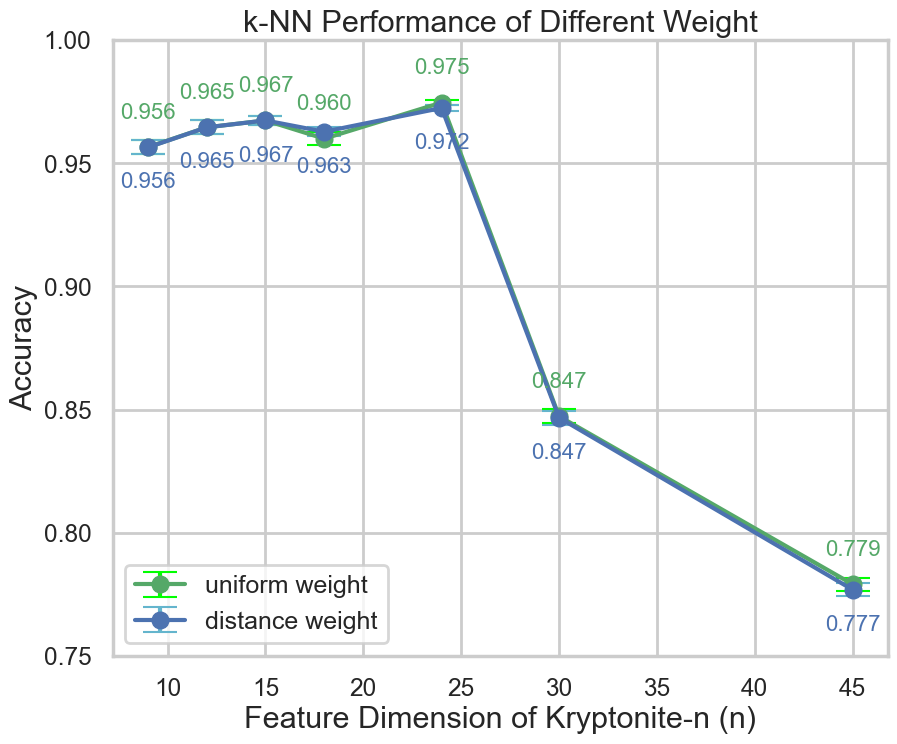

In [11]:
n = [9, 12, 15, 18, 24, 30, 45]
plt.rcdefaults()
plt.figure(figsize=(10, 8))
sns.set(style="whitegrid")
sns.set_context("poster", font_scale=0.8)
plt.errorbar(n, means_reduction, label='uniform weight', yerr=std_devs_reduction, marker='o', linestyle='-', color='g',
             ecolor='lime', capsize=12, capthick=1.5)
plt.errorbar(n, means_distance, label='distance weight', yerr=std_devs_distance, marker='o', linestyle='-', color='b',
             ecolor='c', capsize=12, capthick=1.5)

for x, y in zip(dimensions, means_distance):
    plt.text(x, y - 0.01, f'{y:.3f}', ha='center', va='top', color='b', fontsize=16)
for x, y in zip(dimensions, means_reduction):
    plt.text(x, y + 0.01, f'{y:.3f}', ha='center', va='bottom', color='g', fontsize=16)

plt.ylim(0.75, 1.)
plt.xlabel("Feature Dimension of Kryptonite-n (n)", fontsize=22)
plt.ylabel('Accuracy', fontsize=22)
plt.title('k-NN Performance of Different Weight', fontsize=22)
plt.grid(True)
plt.legend(fontsize=18, loc='lower left')
plt.show()

# Predict new datasets

In [13]:
dimensions = [9, 12, 15, 18, 24, 30, 45]
root = "./datasets/"
for dim in dimensions:
    with open(f"./results/knn_best_config_dim{dim}.json", "r") as f:
        best = json.load(f)
    data, labels = load_data_by_dimension(dim)
    # data, _ = preprocess_data(data, variance_threshold=best["Threshold"])
    data = data[:,best["Features"]]

    model = KNeighborsClassifier(n_neighbors=best["K"])
    model.fit(data, labels)

    data_filename = root + f'hidden-kryptonite-{dim}-X.npy'
    hidden_data = np.load(data_filename)
    # print(best["Features"])
    hidden_data = hidden_data[:,best["Features"]]
    y_pred = model.predict(hidden_data)
    np.save(f'y_predicted_{dim}.npy', y_pred)

Loaded dataset with dimension 9. Data shape: (18000, 9), Labels shape: (18000,)
Loaded dataset with dimension 12. Data shape: (24000, 12), Labels shape: (24000,)
Loaded dataset with dimension 15. Data shape: (30000, 15), Labels shape: (30000,)
Loaded dataset with dimension 18. Data shape: (36000, 18), Labels shape: (36000,)
Loaded dataset with dimension 24. Data shape: (48000, 24), Labels shape: (48000,)
Loaded dataset with dimension 30. Data shape: (60000, 30), Labels shape: (60000,)
Loaded dataset with dimension 45. Data shape: (90000, 45), Labels shape: (90000,)
